In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#데이터 증강에 필요한 라이브러리
from scipy.ndimage import median_filter, rotate, shift
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
df = pd.read_pickle("/home/unsi/다운로드/LSWMD.pkl") 
df

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]
...,...,...,...,...,...,...
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]


In [3]:
df['waferMap'][0].shape

(45, 48)

In [4]:
# failureType 열의 데이터 유형과 샘플 값 확인
print(df['failureType'].head(50))  # 상위 50개의 데이터를 확인


0         [[none]]
1         [[none]]
2         [[none]]
3         [[none]]
4         [[none]]
5         [[none]]
6         [[none]]
7         [[none]]
8         [[none]]
9         [[none]]
10        [[none]]
11        [[none]]
12        [[none]]
13        [[none]]
14        [[none]]
15        [[none]]
16        [[none]]
17        [[none]]
18        [[none]]
19         [[Loc]]
20        [[none]]
21        [[none]]
22        [[none]]
23        [[none]]
24        [[none]]
25        [[none]]
26        [[none]]
27        [[none]]
28        [[none]]
29        [[none]]
30        [[none]]
31        [[none]]
32        [[none]]
33        [[none]]
34        [[none]]
35              []
36    [[Edge-Loc]]
37    [[Edge-Loc]]
38    [[Edge-Loc]]
39    [[Edge-Loc]]
40         [[Loc]]
41    [[Edge-Loc]]
42    [[Edge-Loc]]
43    [[Edge-Loc]]
44      [[Center]]
45              []
46        [[none]]
47         [[Loc]]
48    [[Edge-Loc]]
49      [[Center]]
Name: failureType, dtype: object


In [5]:
import numpy as np

# class2idx 딕셔너리 (예시)
class2idx = {
    'Loc': 0,
    'Edge-Loc': 1,
    'Center': 2,
    'Edge-Ring': 3,
    'Scratch': 4,
    'Random': 5,
    'Near-full': 6,
    'Donut': 7
}

def map_failure_type(failure_list):
    # numpy array를 리스트로 변환
    if isinstance(failure_list, np.ndarray):
        failure_list = failure_list.tolist()

    # 문자열로 변환
    failure_str = str(failure_list)

    # 'none' 또는 None 문자열 처리
    if "none" in failure_str or failure_list == []:
        return 8

    # 리스트 안에 첫 번째 원소를 가져오기
    try:
        first_element = eval(failure_str)[0][0]  # 첫 번째 리스트의 첫 번째 요소
        return class2idx.get(first_element, 8)
    except (IndexError, SyntaxError):
        return 8

# apply로 처리
df['failureType'] = df['failureType'].apply(map_failure_type)

# 결과 확인
print(df['failureType'])

0         8
1         8
2         8
3         8
4         8
         ..
811452    3
811453    1
811454    3
811455    8
811456    8
Name: failureType, Length: 811457, dtype: int64


In [6]:
df['waferMap'][0].shape

(45, 48)

In [7]:
df.info()
df[df['failureType'] != 8]
df = df[df['waferMap'].apply(lambda x: x.shape == (26, 26))]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 37.1+ MB


In [8]:
df['waferMap'][150].shape

(26, 26)

In [9]:
# failureType의 고유 값과 개수 세기
failure_counts = df['failureType'].value_counts()

print(failure_counts)

failureType
8    29201
0      297
1      296
2       90
5       74
4       72
3       31
6       16
7        1
Name: count, dtype: int64


In [10]:
features = df['waferMap'].values
targets = df['failureType'].values

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 결함 유형 8을 새로운 라벨 7로 변환 (필요할 경우)
targets = np.where(targets == 8, 7, targets)

# 데이터 분할 (train, test split)
X_train, X_test, y_train, y_test = train_test_split(features, targets, stratify=targets, random_state=123, test_size=0.2)

print(f"훈련 데이터 수: {X_train.shape[0]}, 테스트 데이터 수: {X_test.shape[0]}")

훈련 데이터 수: 24062, 테스트 데이터 수: 6016


In [12]:
from scipy.ndimage import median_filter
import ast

# 필터링 함수 정의
def apply_median_filter_to_features(features, targets):
    filtered_maps = []
    filtered_targets = []

    for wafer_map, target in zip(features, targets):
        # 문자열이 아닌 ndarray인 경우 처리
        if isinstance(wafer_map, np.ndarray):
            wafer_map_array = wafer_map
        else:
            wafer_map_array = np.array(ast.literal_eval(wafer_map.replace(' ', ',')))

        # 필터 적용: 0은 그대로 두고 1과 2에 대해 필터링 적용
        filtered_map = np.where(wafer_map_array == 0, 0, median_filter(wafer_map_array, size=3))
        filtered_maps.append(filtered_map)
        filtered_targets.append(target)

    return np.array(filtered_maps), np.array(filtered_targets)

In [13]:
# 필터링된 훈련 데이터
filtered_train_X, filtered_train_y = apply_median_filter_to_features(X_train, y_train)
filtered_test_X, filtered_test_Y = apply_median_filter_to_features(X_test, y_test)
print(f"필터링된 훈련 데이터의 형태: {filtered_train_X.shape}")

필터링된 훈련 데이터의 형태: (24062, 26, 26)


In [14]:
X_test.shape, y_test.shape

((6016,), (6016,))

In [15]:
import numpy as np

# X_test의 요소들을 numpy 배열로 변환
X_test_images = np.array(X_test.tolist())  # 리스트로 변환 후 numpy 배열로 변환

# 배열의 형태 확인
print(f"X_test_images shape: {X_test_images.shape}")  # (n_samples, 26, 26)

# reshape을 사용하여 (n_samples, 26*26) 형태로 변환
X_test_reshaped = X_test_images.reshape(-1, 26*26)  # (n_samples, 676)

X_test = X_test_reshaped

# 변환된 형태 출력
print(f"X_test shape: {X_test_reshaped.shape}")  # (n_samples, 676)

X_test_images shape: (6016, 26, 26)
X_test shape: (6016, 676)


In [16]:
X_test.shape, y_test.shape

((6016, 676), (6016,))

In [17]:
X_train_no_aug = X_train
y_train_no_aug = y_train

In [18]:
import numpy as np
from scipy.ndimage import rotate

# 데이터 증강 함수 (Train 데이터만 증강)
def augment_data(wafer_maps, targets):
    augmented_maps = []
    augmented_targets = []

    for wafer_map, target in zip(wafer_maps, targets):
        # 원본 데이터 추가 (리사이즈 없이 그대로)
        augmented_maps.append(wafer_map)
        augmented_targets.append(target)

        # 결함 있는 웨이퍼만 증강 (라벨 7 제외)
        if target != 7:
            # 90도 회전
            augmented_maps.append(rotate(wafer_map, 90))
            augmented_targets.append(target)

            # 상하 및 좌우 뒤집기
            augmented_maps.append(np.flip(wafer_map, axis=0))
            augmented_targets.append(target)

            augmented_maps.append(np.flip(wafer_map, axis=1))
            augmented_targets.append(target)

    return np.array(augmented_maps), np.array(augmented_targets)

# 증강된 훈련 데이터
X_train_aug, y_train_aug = augment_data(X_train_no_aug, y_train_no_aug)

print(f"증강된 훈련 데이터의 형태: {X_train_aug.shape}")

증강된 훈련 데이터의 형태: (26165, 26, 26)


In [19]:
import numpy as np

# 로그 변환을 적용하여 0으로 인한 문제를 피하기 위해 np.log1p 사용 (log(1 + x))
X_train_no_aug = np.array([np.log1p(i) for i in X_train_no_aug])
X_test = np.array([np.log1p(i) for i in X_test])
X_train_aug = np.array([np.log1p(i) for i in X_train_aug])
# 결과 출력
print(X_train_aug[0])
print(X_train_no_aug[0])



[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.6934 1.099  0.6934 0.6934 0.6934 1.099  0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.099  0.6934 0.6934
  0.6934 0.6934 0.6934 1.099  0.6934 0.6934 0.6934 0.6934 1.099  0.
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     1.099  0.6934 0.6934 1.099
  0.6934 0.6934 0.6934 1.099  0.6934 1.099  0.6934 0.6934 0.6934 0.6934
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.6934 0.6934 0.6934 0.6934 0.6934 0.6934
  0.6934 1.099  0.6934 0.6934 0.6934 0.6934 0.6934 1.099  0.6934 0.6934
  0.6934 0.6934 0.     0.     0.     0.    ]
 [0.     0.     0.     0.6934 1.099  1.099  0.6934 0.6934 0.6934 1.099
  0.6934 0.6934 0.6934 0.6934 0.6934 0.6934 0.6934 0.6934 0.6934 1.099
  0.6934 0.6934 0.6934 0.     0.     0.    ]
 [0.     0.     0.6934 0.6934 0.6934 0.6934 0.6934 0.6934 1.099  1.099

In [20]:
print(X_train_aug.shape)

(26165, 26, 26)


In [21]:
import pandas as pd

# 결함 유형별 데이터 개수 세기
augmented_target_series = pd.Series(y_train_aug)
failure_counts_augmented = augmented_target_series.value_counts()

print("증강된 훈련 데이터의 결함 유형별 개수:")
print(failure_counts_augmented)

증강된 훈련 데이터의 결함 유형별 개수:
7    23361
1      948
0      948
2      288
5      236
4      232
3      100
6       52
Name: count, dtype: int64


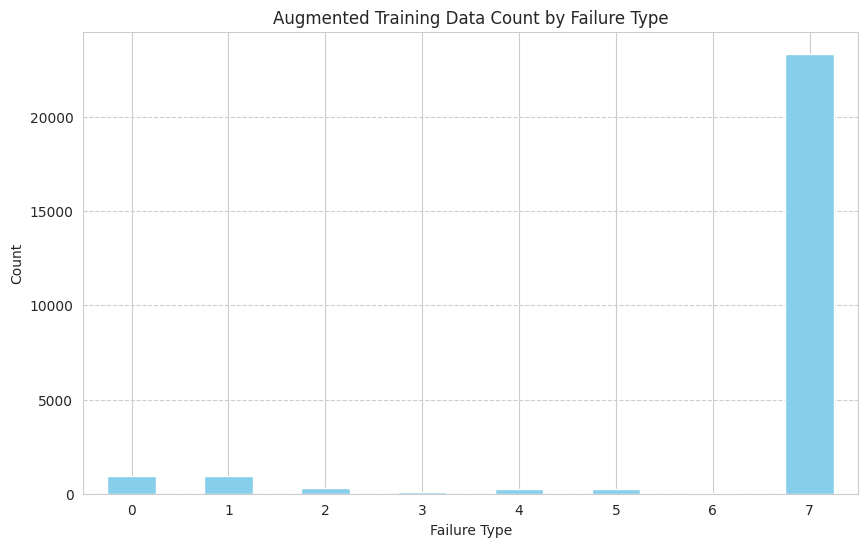

In [22]:
import matplotlib.pyplot as plt

# 결함 유형별 데이터 개수 그래프 그리기
plt.figure(figsize=(10, 6))
failure_counts_augmented.sort_index().plot(kind='bar', color='skyblue')
plt.title('Augmented Training Data Count by Failure Type')
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

In [23]:
import numpy as np
import pandas as pd

# 특징 추출 함수
def extract_features(wafer_maps):
    features = []
    
    for wafer_map in wafer_maps:
        # 1. 결함 다이 비율
        total_pixels = wafer_map.size  # 전체 다이 개수
        defect_count = np.sum(wafer_map == 2)  # 2의 개수
        defect_ratio = defect_count / total_pixels if total_pixels > 0 else 0

        # 2. 결함 분포 (중앙값과 가장자리 근처에 집중되는지)
        defect_indices = np.argwhere(wafer_map == 2)  # 결함 위치의 인덱스
        if defect_indices.size > 0:
            center_of_defects = np.mean(defect_indices, axis=0)  # 결함 위치의 중앙
            distance_to_center = np.linalg.norm(defect_indices - center_of_defects, axis=1)  # 중앙에서의 거리
            avg_distance = np.mean(distance_to_center)  # 평균 거리
        else:
            center_of_defects = np.array([np.nan, np.nan])
            avg_distance = np.nan

        # 3. 픽셀 기반 통계 값 (평균 및 분산)
        mean_value = np.mean(wafer_map)
        variance_value = np.var(wafer_map)

        # 특징 추가
        features.append({
            'defect_ratio': defect_ratio,
            'center_of_defects': center_of_defects,
            'avg_distance_to_center': avg_distance,
            'mean_value': mean_value,
            'variance_value': variance_value
        })

    return pd.DataFrame(features)

# 특징 추출
features_df = extract_features(X_train_aug)

# 결과 확인
print(features_df.head())

   defect_ratio center_of_defects  avg_distance_to_center  mean_value  \
0           0.0        [nan, nan]                     NaN    0.599609   
1           0.0        [nan, nan]                     NaN    0.601074   
2           0.0        [nan, nan]                     NaN    0.590332   
3           0.0        [nan, nan]                     NaN    0.658203   
4           0.0        [nan, nan]                     NaN    0.658203   

   variance_value  
0        0.114258  
1        0.115295  
2        0.108826  
3        0.145752  
4        0.145752  


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


In [24]:
from imblearn.over_sampling import ADASYN
import numpy as np

# ADASYN을 사용한 데이터 증강
def augment_data_with_adasyn(X, y):
    ada = ADASYN(sampling_strategy='auto', random_state=123)
    
    # X를 2D 형태로 변환 (n_samples, 676)
    X_flattened = X.reshape(X.shape[0], -1)
    
    # ADASYN을 적용하여 데이터 증강
    X_resampled, y_resampled = ada.fit_resample(X_flattened, y)
    
    # 1D 형태로 반환 (X_resampled의 shape은 (n_samples, 676))
    return X_resampled, y_resampled

# ADASYN을 사용하여 증강된 훈련 데이터 생성
X_train_aug_with_adsyn, y_train_aug_with_adsyn = augment_data_with_adasyn(X_train_aug, y_train_aug)

print(f"ADASYN으로 증강된 훈련 데이터의 형태: {X_train_aug_with_adsyn.shape}")

ADASYN으로 증강된 훈련 데이터의 형태: (186864, 676)


In [30]:
X_train_aug_with_adsyn.shape

(186864, 676)

In [32]:
X_train_aug = X_train_aug.reshape(-1, 26*26)


In [33]:
X_train_aug.shape

(26165, 676)

In [41]:
X_train_no_aug = X_train_no_aug.reshape(-1, 26*26)


[array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
         0, 0, 0, 0],
        [0, 0, 0, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
         1, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         2, 1, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 0],
        [0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
         1, 1, 1, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
         1, 1, 1, 0],
        [2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1,
         1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 

In [44]:
from sklearn.metrics import classification_report, balanced_accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb

# 공통된 평가 함수 정의
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # 모델 훈련
    model.fit(X_train, y_train)
    
    # 검증 데이터로 예측
    y_pred = model.predict(X_test)
    
    # 성능 지표 계산
    accuracy = model.score(X_test, y_test)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    
    # 결과 출력
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Balanced Accuracy Score: {balanced_acc:.4f}")
    
    # classification_report 출력 (average 파라미터 제거)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

# XGBoost 모델 정의
def create_model():
    return xgb.XGBClassifier(objective='multi:softmax', num_class=8, eval_metric='mlogloss', use_label_encoder=False, device='cuda')

# 모델 및 데이터셋 평가
datasets = [
    ("No Augmentation", X_train_no_aug, y_train_no_aug),
    ("Augmentation", X_train_aug, y_train_aug),
    ("Augmentation with ADASYN", X_train_aug_with_adsyn, y_train_aug_with_adsyn)
]

# 공통된 테스트 데이터 (X_test, y_test)로 각 모델 평가
for dataset_name, X_train, y_train in datasets:
    print(f"\nEvaluating model trained on {dataset_name} dataset")
    model = create_model()
    evaluate_model(model, X_train, y_train, X_test, y_test)



Evaluating model trained on No Augmentation dataset


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:30:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9699
Precision: 0.9619
Recall: 0.9699
F1 Score: 0.9647
Balanced Accuracy Score: 0.4175

Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.13      0.18        60
           1       0.58      0.25      0.35        59
           2       0.54      0.39      0.45        18
           3       0.50      0.17      0.25         6
           4       0.20      0.07      0.11        14
           5       0.45      0.33      0.38        15
           6       0.60      1.00      0.75         3
           7       0.98      0.99      0.98      5841

    accuracy                           0.97      6016
   macro avg       0.52      0.42      0.43      6016
weighted avg       0.96      0.97      0.96      6016


Evaluating model trained on Augmentation dataset


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:30:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9709
Precision: 0.9641
Recall: 0.9709
F1 Score: 0.9663
Balanced Accuracy Score: 0.4461

Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.13      0.18        60
           1       0.65      0.34      0.44        59
           2       0.50      0.33      0.40        18
           3       1.00      0.17      0.29         6
           4       0.20      0.07      0.11        14
           5       0.67      0.53      0.59        15
           6       0.60      1.00      0.75         3
           7       0.98      0.99      0.99      5841

    accuracy                           0.97      6016
   macro avg       0.61      0.45      0.47      6016
weighted avg       0.96      0.97      0.97      6016


Evaluating model trained on Augmentation with ADASYN dataset


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:30:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9704
Precision: 0.9632
Recall: 0.9704
F1 Score: 0.9659
Balanced Accuracy Score: 0.4662

Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.13      0.18        60
           1       0.58      0.32      0.41        59
           2       0.50      0.28      0.36        18
           3       0.67      0.33      0.44         6
           4       0.17      0.07      0.10        14
           5       0.56      0.60      0.58        15
           6       1.00      1.00      1.00         3
           7       0.98      0.99      0.99      5841

    accuracy                           0.97      6016
   macro avg       0.59      0.47      0.51      6016
weighted avg       0.96      0.97      0.97      6016



In [45]:
X_train_no_aug

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float16)

In [46]:
X_train_aug

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float16)

In [47]:
X_train_aug_with_adsyn

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float16)

In [48]:
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 평가 함수 정의
def xgb_evaluate(learning_rate, n_estimators, max_depth, subsample, colsample_bytree):
    # XGBoost 모델 정의
    model = xgb.XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),  # 정수로 변환
        max_depth=int(max_depth),  # 정수로 변환
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective='multi:softmax',
        num_class=8,
        eval_metric='mlogloss',
        use_label_encoder=False,
        device='cuda'
    )
    
    # 교차 검증 데이터로 모델 평가
    model.fit(X_train_aug_with_adsyn, y_train_aug_with_adsyn)
    y_pred = model.predict(X_test)
    accuracy = balanced_accuracy_score(y_test, y_pred)
    
    return accuracy

# 최적화할 파라미터 범위 설정
param_bounds = {
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 500),
    'max_depth': (3, 10),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0)
}

# BayesianOptimization 객체 생성
optimizer = BayesianOptimization(f=xgb_evaluate, pbounds=param_bounds, random_state=42)

# 최적화 수행
optimizer.maximize(init_points=5, n_iter=25)

# 최적화 결과 출력
print(optimizer.max)


|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:42:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 1         | 0.4687    | 0.7498    | 0.2857    | 8.124     | 319.4     | 0.6624    |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:43:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 2         | 0.4523    | 0.6624    | 0.02684   | 9.063     | 320.5     | 0.8832    |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:43:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 3         | 0.4749    | 0.6082    | 0.2913    | 8.827     | 145.6     | 0.6727    |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:44:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 4         | 0.48      | 0.6734    | 0.09823   | 6.673     | 244.4     | 0.7165    |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:44:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 5         | 0.5114    | 0.8447    | 0.05045   | 5.045     | 214.9     | 0.7824    |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:44:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 6         | 0.514     | 0.9913    | 0.05597   | 6.412     | 213.9     | 0.8558    |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:44:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 7         | 0.4675    | 0.6713    | 0.07499   | 8.473     | 217.0     | 0.6401    |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:45:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 8         | 0.5057    | 1.0       | 0.04301   | 4.613     | 212.5     | 0.9493    |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:45:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 9         | 0.4723    | 0.6       | 0.01      | 7.932     | 211.0     | 0.6       |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:45:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 10        | 0.5051    | 1.0       | 0.3       | 3.0       | 214.2     | 1.0       |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:45:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 11        | 0.4843    | 1.0       | 0.3       | 3.0       | 217.8     | 1.0       |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:45:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 12        | 0.5405    | 0.9873    | 0.1314    | 3.201     | 314.1     | 0.7027    |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:46:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 13        | 0.5177    | 0.9988    | 0.3       | 3.0       | 311.7     | 0.6       |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:46:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 14        | 0.4596    | 0.6       | 0.01      | 5.518     | 314.1     | 1.0       |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:46:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 15        | 0.4691    | 1.0       | 0.01      | 3.0       | 313.1     | 1.0       |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:46:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 16        | 0.4949    | 0.9769    | 0.2476    | 3.931     | 303.8     | 0.6537    |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:46:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 17        | 0.5277    | 0.8968    | 0.08977   | 4.454     | 479.8     | 0.9334    |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:47:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 18        | 0.4751    | 0.9716    | 0.2088    | 6.297     | 483.9     | 0.975     |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:47:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 19        | 0.5216    | 0.882     | 0.05902   | 4.398     | 190.4     | 0.6844    |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:47:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 20        | 0.4585    | 0.9694    | 0.1583    | 7.576     | 286.5     | 0.9714    |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:48:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 21        | 0.526     | 0.956     | 0.02978   | 5.955     | 424.5     | 0.7402    |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:48:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 22        | 0.5545    | 0.7531    | 0.2936    | 3.411     | 427.8     | 0.8697    |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:48:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 23        | 0.5246    | 0.7557    | 0.2948    | 3.414     | 427.8     | 0.8724    |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:48:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 24        | 0.546     | 0.907     | 0.06658   | 3.666     | 454.6     | 0.6102    |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:49:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 25        | 0.4752    | 0.9671    | 0.1219    | 7.632     | 178.8     | 0.6621    |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:49:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 26        | 0.4487    | 0.7489    | 0.1263    | 9.43      | 378.3     | 0.6488    |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:50:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 27        | 0.4862    | 0.8265    | 0.1579    | 6.617     | 452.0     | 0.9872    |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:50:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 28        | 0.4486    | 0.7827    | 0.2907    | 7.917     | 231.7     | 0.9745    |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:50:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 29        | 0.5107    | 0.816     | 0.2258    | 4.264     | 394.2     | 0.7215    |


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:51:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| 30        | 0.4509    | 0.603     | 0.04922   | 7.806     | 451.3     | 0.7005    |
{'target': np.float64(0.5544901191087631), 'params': {'colsample_bytree': np.float64(0.753077079071562), 'learning_rate': np.float64(0.29358019497813675), 'max_depth': np.float64(3.410942951140787), 'n_estimators': np.float64(427.8017218791534), 'subsample': np.float64(0.8697193641758865)}}


In [49]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

# 최적의 하이퍼파라미터를 사용한 최종 테스트 함수
def final_test_with_best_params(optimizer, X_train, y_train, X_test, y_test):
    # 베이지안 최적화로 얻은 최적의 하이퍼파라미터 추출
    best_params = optimizer.max['params']
    
    # 최적의 하이퍼파라미터로 XGBoost 모델 학습
    model = xgb.XGBClassifier(
        learning_rate=best_params['learning_rate'],
        n_estimators=int(best_params['n_estimators']),  # 정수로 변환
        max_depth=int(best_params['max_depth']),  # 정수로 변환
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        objective='multi:softmax',
        num_class=8,
        eval_metric='mlogloss',
        use_label_encoder=False,
        device='cuda'
    )
    
    # 최적 하이퍼파라미터로 모델 학습
    model.fit(X_train, y_train)
    
    # 테스트 데이터로 예측
    y_pred = model.predict(X_test)
    
    # 성능 지표 계산
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    
    # 결과 출력
    print(f"Final Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Balanced Accuracy Score: {balanced_acc:.4f}")
    
    # Classification Report 출력
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 최종 테스트 실행
final_test_with_best_params(optimizer, X_train_aug_with_adsyn, y_train_aug_with_adsyn, X_test, y_test)


/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:52:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Final Model Performance:
Accuracy: 0.9726
Precision: 0.9669
Recall: 0.9726
F1 Score: 0.9689
Balanced Accuracy Score: 0.5545

Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.17      0.22        60
           1       0.65      0.37      0.47        59
           2       0.60      0.50      0.55        18
           3       0.80      0.67      0.73         6
           4       0.20      0.07      0.11        14
           5       0.56      0.67      0.61        15
           6       0.60      1.00      0.75         3
           7       0.98      0.99      0.99      5841

    accuracy                           0.97      6016
   macro avg       0.59      0.55      0.55      6016
weighted avg       0.97      0.97      0.97      6016

